/usr/local/cuda-12.2/targets/x86_64-linux/lib:/usr/local/cuda-12.2/targets/x86_64-linux/lib::/u/dssc/mnunzi00/Python-3.10.15/::/u/dssc/mnunzi00/Python-3.10.15/:/u/dssc/mnunzi00/.sofa/lib:/u/dssc/mnunzi00/Python-3.10.15/:/u/dssc/mnunzi00/.sofa/lib:/u/dssc/mnunzi00/sofa_env/SOFA/lib:

In [1]:
from collections import defaultdict
import random
import gymnasium.spaces as spaces
import numpy as np

from enum import Enum, unique
from pathlib import Path
from typing import Any, Dict, Optional, Tuple, Union, List, Callable
from functools import reduce

import Sofa
import Sofa.Core

from sofa_env.base import RenderMode, SofaEnv, RenderFramework
from sofa_env.scenes.grasp_lift_touch.sofa_objects.liver import Liver
from sofa_env.utils.camera import world_to_pixel_coordinates
from sofa_env.utils.math_helper import distance_between_line_segments, farthest_point_sampling

from sofa_env.scenes.grasp_lift_touch.sofa_objects.point_of_interest import PointOfInterest
from sofa_env.scenes.grasp_lift_touch.sofa_objects.cauter import Cauter
from sofa_env.scenes.grasp_lift_touch.sofa_objects.gallbladder import Gallbladder
from sofa_env.scenes.grasp_lift_touch.sofa_objects.gripper import Gripper
from sofa_env.utils.math_helper import farthest_point_sampling
from sofa_env.utils.motion_planning import create_linear_motion_action_plan

HERE = Path("grasp_lift_touch").resolve().parent
SCENE_DESCRIPTION_FILE_PATH = HERE / "scene_description.py"


@unique
class ObservationType(Enum):
    """Observation type specifies whether the environment step returns RGB images or a defined state"""

    RGB = 0
    STATE = 1
    RGBD = 2


@unique
class Phase(Enum):
    GRASP = 0
    LIFT = 1
    TOUCH = 2
    DONE = 3
    ANY = 4

    def __le__(self, other):
        if self.__class__ is other.__class__:
            return self.value <= other.value
        return NotImplemented

    def __ge__(self, other):
        if self.__class__ is other.__class__:
            return self.value >= other.value
        return NotImplemented

    def __eq__(self, other):
        if self.__class__ is other.__class__:
            return self.value == other.value
        return NotImplemented

    def __hash__(self):
        return hash(self._name_)


@unique
class CollisionEffect(Enum):
    """Collision effect specifies how collisions are punished. Proportial to the number of collisions, constant for collision/not collison, or ending the episode."""

    PROPORTIONAL = 0
    CONSTANT = 1
    FAILURE = 2


@unique
class ActionType(Enum):
    DISCRETE = 0
    CONTINUOUS = 1
    VELOCITY = 2
    POSITION = 3


class GraspLiftTouchEnv(SofaEnv):
    """Grasp Lift and Touch Environment

    The goal of this environment is to grasp the infundibulum of a gallbladder, lift the gallbladder to expose a target point,
    and touch the target point with a electrocautery hook.

    Notes:
        - We only consider a grasp successful if it was established on the infundibulum of the gallbladder.

    Args:
        scene_path (Union[str, Path]): Path to the scene description script that contains this environment's ``createScene`` function.
        image_shape (Tuple[int, int]): Height and Width of the rendered images.
        observation_type (ObservationType): Whether to return RGB images or an array of states as the observation.
        time_step (float): size of simulation time step in seconds (default: 0.01).
        frame_skip (int): number of simulation time steps taken (call ``_do_action`` and advance simulation) each time step is called (default: 1).
        settle_steps (int): How many steps to simulate without returning an observation after resetting the environment.
        render_mode (RenderMode): Create a window (``RenderMode.HUMAN``), run headless (``RenderMode.HEADLESS``), or do not create a render buffer at all (``RenderMode.NONE``).
        render_framework (RenderFramework): choose between pyglet and pygame for rendering
        start_in_phase (Phase): The phase the environment starts in for the reset.
        end_in_phase (Phase): The phase the environment ends in for the done signal.
        tool_collision_distance (float): Distance in mm at which the tool is considered to be in collision with each other.
        goal_tolerance (float): Distance between cauter and target point in mm at which the goal is considered to be reached.
        create_scene_kwargs (Optional[dict]): A dictionary to pass additional keyword arguments to the ``createScene`` function.
        maximum_state_velocity (Union[np.ndarray, float]): Velocity in deg/s for pts and mm/s for d in state space which are applied with a normalized action of value 1.
        discrete_action_magnitude (Union[np.ndarray, float]): Discrete change in state space in deg/s for pts and mm/s for d.
        individual_agents (bool): Wether the instruments are individually (dictionary action space).
        individual_rewards (bool): Whether the rewards are assigned individually to each instrument (dictionary reward).
        action_type (ActionType): Discrete or continuous actions to define the action space of the environment.
        on_reset_callbacks (Optional[List[Callable]]): Functions that are called as the last step of the ``env.reset()`` function.
        reward_amount_dict (dict): Dictionary to weigh the components of the reward function.
        collision_punish_mode (CollisionEffect): How to punish collisions.
        losing_grasp_ends_episode (bool): Whether losing the grasp ends the episode.
        num_gallbladder_tracking_points (int): Number of points on the gallbladder to track for state observations.
        randomize_gallbladder_tracking_points (bool): Whether to pick a new set of indices for the tracking points on the gallbladder for each reset.
        randomize_point_of_interest (bool): Whether to pick a new point of interest for each reset.
        max_gallbladder_liver_overlap (float): Amount of overlap between the gallbladder and the liver to accept before blocking the done signal.
        gallbladder_force_scaling_factor (float): Scaling factor for the force measured in the gallbladder (see reward function).
        limit_grasping_attempts_in_reset (bool): Whether to limit the number of grasping attempts in the reset function, if the starting phase is past the grasping phase.
        cauter_has_to_activate_in_target (bool): Whether the cauter has to be activated in the target point to end the episode.
    """

    def __init__(
        self,
        scene_path: Union[str, Path] = SCENE_DESCRIPTION_FILE_PATH,
        image_shape: Tuple[int, int] = (512, 512),
        observation_type: ObservationType = ObservationType.RGB,
        time_step: float = 0.1,
        frame_skip: int = 1,
        settle_steps: int = 10,
        render_mode: RenderMode = RenderMode.HEADLESS,
        render_framework: RenderFramework = RenderFramework.PYGLET,
        start_in_phase: Phase = Phase.GRASP,
        end_in_phase: Phase = Phase.DONE,
        tool_collision_distance: float = 5.0,
        goal_tolerance: float = 5.0,
        create_scene_kwargs: Optional[dict] = None,
        maximum_state_velocity: Union[np.ndarray, float] = np.array([15.0, 15.0, 25.0, 25.0, 20.0]),
        discrete_action_magnitude: Union[np.ndarray, float] = np.array([10.0, 10.0, 15.0, 15.0, 12.0]),
        individual_agents: bool = True,
        individual_rewards: bool = False,
        action_type: ActionType = ActionType.CONTINUOUS,
        on_reset_callbacks: Optional[List[Callable]] = None,
        reward_amount_dict: dict = {
            Phase.ANY: {
                "collision_cauter_gripper": -0.0,
                "collision_cauter_gallbladder": -0.0,
                "collision_cauter_liver": -0.0,
                "collision_gripper_liver": -0.0,
                "distance_cauter_target": -0.0,
                "delta_distance_cauter_target": -0.0,
                "target_visible": 0.0,
                "gallbladder_is_grasped": 0.0,
                "new_grasp_on_gallbladder": 0.0,
                "lost_grasp_on_gallbladder": -0.0,
                "active_grasping_springs": 0.0,
                "delta_active_grasping_springs": 0.0,
                "gripper_pulls_gallbladder_out": 0.0,
                "overlap_gallbladder_liver": -0.0,
                "dynamic_force_on_gallbladder": -0.0,
                "delta_overlap_gallbladder_liver": -0.0,
                "successful_task": 0.0,
                "failed_task": -0.0,
                "cauter_action_violated_state_limits": -0.0,
                "cauter_action_violated_cartesian_workspace": -0.0,
                "gripper_action_violated_state_limits": -0.0,
                "gripper_action_violated_cartesian_workspace": -0.0,
                "phase_change": 0.0,
            },
            Phase.GRASP: {
                "distance_gripper_graspable_region": -0.0,
                "delta_distance_gripper_graspable_region": -0.0,
            },
            Phase.TOUCH: {
                "cauter_activation_in_target": 0.0,
                "cauter_delta_activation_in_target": 0.0,
                "cauter_touches_target": 0.0,
            },
        },
        collision_punish_mode: CollisionEffect = CollisionEffect.CONSTANT,
        losing_grasp_ends_episode: bool = False,
        num_gallbladder_tracking_points: int = 10,
        randomize_gallbladder_tracking_points: bool = True,
        randomize_point_of_interest: bool = True,
        max_gallbladder_liver_overlap: float = 0.1,
        gallbladder_force_scaling_factor: float = 1e-9,
        limit_grasping_attempts_in_reset: bool = False,
        cauter_has_to_activate_in_target: bool = True,
    ):
        # Pass image shape to the scene creation function
        if not isinstance(create_scene_kwargs, dict):
            create_scene_kwargs = {}
        create_scene_kwargs["image_shape"] = image_shape

        create_scene_kwargs["randomize_poi_position"] = randomize_point_of_interest

        if render_mode == RenderMode.NONE:
            raise ValueError("This environment does not support render mode NONE, use HEADLESS instead. We need to render the scene to check if the target is visible to the camera which is part of the LIFT phase of the task.")

        super().__init__(
            scene_path=scene_path,
            time_step=time_step,
            frame_skip=frame_skip,
            render_mode=render_mode,
            render_framework=render_framework,
            create_scene_kwargs=create_scene_kwargs,
        )

        # In which phase of the task to start. Enables skipping the grasping / lifting
        self.starting_phase = start_in_phase
        self.limit_grasping_attempts_in_reset = limit_grasping_attempts_in_reset

        # In which phase of the task to end. Enables skipping lifting / touching
        if end_in_phase <= start_in_phase:
            raise ValueError(f"The end phase should be after the selected start phase. {start_in_phase=}    {end_in_phase=}")
        else:
            self.ending_phase: Phase = end_in_phase

        # How many simulation steps to wait before starting the episode
        self._settle_steps = settle_steps

        # Observation type of the env observation_space
        self.observation_type = observation_type

        # How close the tool axis have to be to each other to be considered in collision
        self.tool_collision_distance = tool_collision_distance

        # How are collisions punished? (proportional to the number of contacts, constant value, ending an episode early)
        self.collision_punish_mode = collision_punish_mode

        # How close the tool needs to be to the target to be considered successful
        self.goal_tolerance = goal_tolerance

        # All parameters of the reward function that are not passed default to 0.0
        self.reward_amount_dict = defaultdict(dict) | {phase: defaultdict(float, **reward_dict) for phase, reward_dict in reward_amount_dict.items()}

        # Split the reward parts for the individual agents
        self.individual_rewards = individual_rewards
        self.agent_specific_rewards = defaultdict(float)

        # Does losing a grasp end an episode early?
        self.losing_grasp_ends_episode = losing_grasp_ends_episode

        # Does the cauter have to activate in the target, or just touch the target?
        self.cauter_has_to_activate_in_target = cauter_has_to_activate_in_target

        # How much of the gallbladder is allowed to be in the liver, before blocking the done signal of the LIFT phase
        self.max_gallbladder_liver_overlap = max_gallbladder_liver_overlap

        # How much to scale down the forces read from the gallbladder MechanicalObject, before passing them to the reward function
        self.gallbladder_force_scaling_factor = gallbladder_force_scaling_factor

        # Infos per episode
        self.episode_info = defaultdict(float)

        # Infos from the reward
        self.reward_info = {}
        self.reward_features = {}

        # Callback functions called on reset
        self.on_reset_callbacks = on_reset_callbacks if on_reset_callbacks is not None else []

        ###########################
        # Set up observation spaces
        ###########################

        # How many points on the gallbladder surface to include in the state observations
        self.num_gallbladder_tracking_points = num_gallbladder_tracking_points
        self.randomize_gallbladder_tracking_points = randomize_gallbladder_tracking_points
        if self.observation_type == ObservationType.STATE:
            # pose of the gripper -> 7
            # pose of the cauter -> 7
            # ptsda_state gripper -> 5
            # ptsda_state cauter -> 5
            # target position -> 3
            # gripper has grasped -> 1
            # phase -> 1
            # tracking points on the gallbladder surface
            observations_size = 7 + 7 + 5 + 5 + 3 + 1 + 1 + 3 * self.num_gallbladder_tracking_points
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(observations_size,), dtype=np.float32)
        elif self.observation_type == ObservationType.RGB:
            self.observation_space = spaces.Box(low=0, high=255, shape=image_shape + (3,), dtype=np.uint8)

        elif self.observation_type == ObservationType.RGBD:
            self.observation_space = spaces.Box(low=0, high=255, shape=image_shape + (4,), dtype=np.uint8)

        else:
            raise ValueError(f"Unknown observation type {self.observation_type}.")

        ######################
        # Set up action spaces
        ######################
        self.action_type = action_type
        action_dimensionality = 5
        
        self.camera_action_dimensionality = 7
        self.camera_max_state_velocity = 0. * np.array([.0, .0, .0, 1.0, 1.0, 1.0, 1.0]) # da sostituire con maximum_state_velocity

        self._maximum_state_velocity = maximum_state_velocity
        self._discrete_action_magnitude = discrete_action_magnitude
        if individual_agents:
            self._do_action = self._do_action_dict
            if action_type == ActionType.CONTINUOUS:
                self.action_space = spaces.Dict(
                    {
                        "gripper": spaces.Box(low=-1.0, high=1.0, shape=(action_dimensionality,), dtype=np.float32),
                        "cauter": spaces.Box(low=-1.0, high=1.0, shape=(action_dimensionality,), dtype=np.float32),
                        "camera": spaces.Box(low=-1.0, high=1.0, shape=(self.camera_action_dimensionality,), dtype=np.float32),
                    }
                )
                self._scale_action = self._scale_continuous_action
                self._scale_camera_action = self._scale_continuous_camera_action

            elif action_type == ActionType.POSITION:
                # Same as the state limits of the instruments
                action_space_limits = {
                    "low": np.array([-75.0, -40.0, -1000.0, 12.0]),
                    "high": np.array([75.0, 75.0, 1000.0, 300.0]),
                }
                self.action_space = spaces.Dict(
                    {
                        "gripper": spaces.Box(
                            low=np.append(action_space_limits["low"], 0.0),
                            high=np.append(action_space_limits["high"], 60.0),
                            shape=(action_dimensionality,),
                            dtype=np.float32,
                        ),
                        "cauter": spaces.Box(
                            low=np.append(action_space_limits["low"], -1.0),
                            high=np.append(action_space_limits["high"], 1.0),
                            shape=(action_dimensionality,),
                            dtype=np.float32,
                        ),
                    }
                )
            elif action_type == ActionType.VELOCITY:
                raise NotImplementedError("Velocity actions are not yet implemented.")

            else:
                self.action_space = spaces.Dict(
                    {
                        "gripper": spaces.Discrete(action_dimensionality * 2 + 1),
                        "cauter": spaces.Discrete(action_dimensionality * 2 + 1),
                    }
                )

                self._scale_action = self._scale_discrete_action
                if isinstance(discrete_action_magnitude, np.ndarray):
                    if not len(discrete_action_magnitude) == action_dimensionality:
                        raise ValueError("If you want to use individual discrete action step sizes per action dimension, please pass an array of length {action_dimensionality} as discrete_action_magnitude. Received {discrete_action_magnitude=} with lenght {len(discrete_action_magnitude)}.")

                # [step, 0, 0, ...], [-step, 0, 0, ...], [0, step, 0, ...], [0, -step, 0, ...]
                action_list = []
                for i in range(action_dimensionality * 2):
                    action = [0.0] * action_dimensionality
                    step_size = discrete_action_magnitude if isinstance(discrete_action_magnitude, float) else discrete_action_magnitude[int(i / 2)]
                    action[int(i / 2)] = (1 - 2 * (i % 2)) * step_size
                    action_list.append(action)

                # Noop action
                action_list.append([0.0] * action_dimensionality)

                self._discrete_action_lookup = np.array(action_list)
                self._discrete_action_lookup *= self.time_step
                self._discrete_action_lookup.flags.writeable = False
        else:
            self._do_action = self._do_action_array
            if action_type == ActionType.CONTINUOUS:
                self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(action_dimensionality * 2,), dtype=np.float32)
                self._scale_action = self._scale_continuous_action
            elif action_type == ActionType.POSITION:
                # Same as the state limits of the instruments
                action_space_limits = {
                    "low": np.array([-75.0, -40.0, -1000.0, 12.0, -1.0] * 2),
                    "high": np.array([75.0, 75.0, 1000.0, 300.0, 1.0] * 2),
                }

                # Adapt the angle limits of the gripper
                action_space_limits["low"][4] = 0.0
                action_space_limits["high"][4] = 90.0

                self.action_space = spaces.Box(low=action_space_limits["low"], high=action_space_limits["high"], shape=(action_dimensionality * 2,), dtype=np.float32)
            elif action_type == ActionType.VELOCITY:
                raise NotImplementedError("Velocity actions are not yet implemented.")
            else:
                raise NotImplementedError("GraspLiftTouchEnv currently only supports continuous actions for non-individual agents.")

    def _do_action(self, action) -> None:
        """Only defined to satisfy ABC."""
        pass

    def _do_action_dict(self, action: Dict[str, np.ndarray]) -> None:
        """Apply action to the simulation."""
        self._do_action_camera(action["camera"])

        if self.action_type == ActionType.POSITION:
            self.gripper.set_articulated_state(action["gripper"])
            self.cauter.set_extended_state(action["cauter"])
        else:
            self.gripper.do_action(self._scale_action(action["gripper"]))
            self.cauter.do_action(self._scale_action(action["cauter"]))
    
    def _do_action_camera(self, action: Union[np.ndarray, int]) -> None:
        """Apply the ``camera`` action to the simulation."""
        self.camera.set_pose(self.camera.get_camera_pose() + self._scale_camera_action(action))

    def _do_action_array(self, action: np.ndarray) -> None:
        """Apply action to the simulation."""
        if self.action_type == ActionType.POSITION:
            self.gripper.set_articulated_state(action[:5])
            self.cauter.set_extended_state(action[5:])
        else:
            self.gripper.do_action(self._scale_action(action[:5]))
            self.cauter.do_action(self._scale_action(action[5:]))

    def _scale_discrete_action(self, action: int) -> np.ndarray:
        """Maps action indices to a motion delta."""
        return self._discrete_action_lookup[action]

    def _scale_continuous_action(self, action: np.ndarray) -> np.ndarray:
        """
        Policy is output is clipped to [-1, 1] e.g. [-0.3, 0.8, 1].
        We want to scale that to the maximum velocities defined
        in ``maximum_state_velocity`` in [angle, angle, angle, mm, angle | activation] / step.
        and further to per second (because delta T is not 1 second).
        """
        return self.time_step * self._maximum_state_velocity * action
    
    def _scale_continuous_camera_action(self, action: np.ndarray) -> np.ndarray:
        """
        Policy is output is clipped to [-1, 1] e.g. [-0.3, 0.8, 1].
        We want to scale that to the maximum velocities defined
        in ``maximum_state_velocity`` in [angle, angle, angle, mm, angle] / step.
        and further to per second (because delta T is not 1 second).
        """
        continuous_action = self.time_step * self.camera_max_state_velocity * action[: self.camera_action_dimensionality]
        return continuous_action

    def _init_sim(self) -> None:
        super()._init_sim()
        self.gripper: Gripper = self.scene_creation_result["interactive_objects"]["gripper"]
        self.cauter: Cauter = self.scene_creation_result["interactive_objects"]["cauter"]
        self.gallbladder: Gallbladder = self.scene_creation_result["gallbladder"]
        self.liver: Liver = self.scene_creation_result["liver"]
        self.poi: PointOfInterest = self.scene_creation_result["poi"]
        self.contact_listener: Dict[str, Sofa.Core.ContactListener] = self.scene_creation_result["contact_listener"]
        self.camera = self.scene_creation_result["camera"]
        self.liver_force_field = self.scene_creation_result["liver_force_field"]
        self.gallbladder_force_field = self.scene_creation_result["gallbladder_force_field"]

        self.target_position = np.empty(3, dtype=np.float32)
        self._distance_normalization_factor = 1.0 / np.linalg.norm(self.gripper.cartesian_workspace["high"] - self.gripper.cartesian_workspace["low"])

    def step(self, action: Any) -> Tuple[Union[np.ndarray, dict], float, bool, bool, dict]:
        """Step function of the environment that applies the action to the simulation and returns observation, reward, done signal, and info."""

        image_observation = super().step(action)
        observation = self._get_observation(image_observation)
        reward = self._get_reward(image=image_observation)
        terminated = self._get_done()
        info = self._get_info()

        return observation, reward, terminated, False, info

    def _get_info(self) -> dict:
        """Assemble the info dictionary."""

        self.info = {}
        self.info["final_phase"] = self.active_phase.value

        for key, value in self.reward_info.items():
            # shortens 'reward_delta_gripper_distance_to_torus_tracking_points'
            # to 'ret_del_gri_dis_to_tor_tra_poi'
            words = key.split("_")[1:]
            shortened_key = reduce(lambda x, y: x + "_" + y[:3], words, "ret")
            self.episode_info[shortened_key] += value

        return {**self.info, **self.reward_info, **self.episode_info, **self.reward_features, **self.agent_specific_rewards}

    def _get_done(self) -> bool:
        """Look up if the episode is finished."""
        return self.reward_info["successful_task"] or self.reward_info["failed_task"]

    def _get_observation(self, image_observation: Union[np.ndarray, None]) -> Union[np.ndarray, dict]:
        if self.observation_type == ObservationType.RGB:
            return image_observation.copy()
        elif self.observation_type == ObservationType.RGBD:
            observation = self.observation_space.sample()
            observation[:, :, :3] = image_observation.copy()
            observation[:, :, 3:] = self.get_depth()
            return observation
        else:
            state_dict = {}
            state_dict["gripper_pose"] = self.gripper.get_physical_pose()
            state_dict["cauter_pose"] = self.cauter.get_physical_pose()
            state_dict["gripper_ptsda"] = self.gripper.get_ptsda_state()
            state_dict["cauter_ptsda"] = self.cauter.get_ptsda_state()
            state_dict["gripper_has_grasped"] = np.asarray(float(self.gripper.grasp_established))[None]  # 1 -> [1]
            state_dict["target_position"] = self.target_position
            state_dict["phase"] = np.asarray(float(self.active_phase.value))[None]  # 1 -> [1]
            state_dict["gallbladder_tracking_points"] = self.gallbladder_surface_mechanical_object.position.array()# [self.gallbladder_tracking_indices].ravel()
            return state_dict
            return np.concatenate(tuple(state_dict.values()))

    def reset(self, seed: Union[int, np.random.SeedSequence, None] = None, options: Optional[Dict[str, Any]] = None) -> Tuple[Union[np.ndarray, None], Dict]:
        super().reset(seed)

        # Seed the instruments
        if self.unconsumed_seed:
            seeds = self.seed_sequence.spawn(3)
            self.gripper.seed(seed=seeds[0])
            self.cauter.seed(seed=seeds[1])
            self.poi.seed(seed=seeds[2])

            # Select indices on the gallbladder surface as tracking points for state observations
            self.gallbladder_surface_mechanical_object = self.gallbladder.collision_model_node.MechanicalObject
            gallbladder_surface_points = self.gallbladder_surface_mechanical_object.position.array()
            if self.randomize_gallbladder_tracking_points:
                first_gallbladder_tracking_point_index = self.rng.integers(low=0, high=len(gallbladder_surface_points), endpoint=False)
            else:
                first_gallbladder_tracking_point_index = 0
            tracking_point_indices = farthest_point_sampling(
                gallbladder_surface_points,
                self.num_gallbladder_tracking_points,
                starting_point_index=first_gallbladder_tracking_point_index,
                return_indices=True,
            )
            self.gallbladder_tracking_indices = tracking_point_indices
            self.unconsumed_seed = False

        # Reset the phase to the one set on environment creation
        self.active_phase = self.starting_phase

        # Reset Point of Interest
        self.poi.reset()
        self.target_position[:] = self.poi.pose[:3]
        self.target_position_in_image = world_to_pixel_coordinates(self.target_position, self.scene_creation_result["camera"].sofa_object)

        # Reset tools
        self.gripper.reset_gripper()
        self.cauter.reset_cauter()

        # Save the indices that describe indices on the gallbladder that might be suitable for grasping
        self.gallbladder_indices_in_grasping_roi = self.gallbladder.graspable_region_box.indices.array().copy()
        self.gallbladder_indices_in_grasping_roi_collision = self.gallbladder.graspable_region_box_collision.indices.array().copy()

        if self.active_phase >= Phase.LIFT:
            if self.active_phase >= Phase.DONE:
                raise ValueError(f"Was asked to reset the environment to {self.active_phase}. This is not possible.")

            grasping_attempts = 0
            skip_random_grasping = False
            while not self.gripper.grasp_established:
                # Move the gripper to the gallbladder.
                optimal_state = np.array([3.0, 20.0, 95.0, 215.0, 30.0])
                if self.gripper.ptsd_reset_noise is not None and not skip_random_grasping:
                    optimal_state += self.rng.uniform(-3.0, 3.0, optimal_state.shape)
                action_plan = create_linear_motion_action_plan(optimal_state, self.gripper.get_ptsda_state(), self.time_step, self._maximum_state_velocity)
                for action in action_plan:
                    self.gripper.do_action(action)
                    self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())
                    if self.internal_render_mode == RenderMode.HUMAN:
                        self._maybe_update_rgb_buffer()

                # Close the gripper jaws
                optimal_state[-1] = 5.0
                action_plan = create_linear_motion_action_plan(optimal_state, self.gripper.get_ptsda_state(), self.time_step, self._maximum_state_velocity)
                for action in action_plan:
                    self.gripper.do_action(action)
                    self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())
                    if self.internal_render_mode == RenderMode.HUMAN:
                        self._maybe_update_rgb_buffer()

                # Animate several timesteps without actions to let the gripper establish a new grasp.
                for _ in range(10):
                    self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())
                    if self.internal_render_mode == RenderMode.HUMAN:
                        self._maybe_update_rgb_buffer()

                # Raise an error, if that is not successful for more than 10 attempts.
                grasping_attempts += 1
                if grasping_attempts > 10 and not skip_random_grasping:
                    skip_random_grasping = True
                    grasping_attempts = 0
                elif grasping_attempts > 10 and skip_random_grasping:
                    if self.limit_grasping_attempts_in_reset:
                        raise RuntimeError(f"Could not grasp the gallbladder on reset to phase {self.active_phase}.")
                    else:
                        print("[Warning] Grasping in reset unsuccessful...trying again with new reset.")
                        self.reset()

            if self.active_phase >= Phase.TOUCH:
                # With the grasped gallbladder, move the gripper up, to expose the visual target.
                target_visible = False

                # If we do not render the scene, figuring out if the target is visible, is not possible.
                # In this case, we just pull outh the gripper very far, to make sure the target is exposed.
                if self.internal_render_mode == RenderMode.NONE:
                    optimal_state = np.array([3.0, 10.0, 95.0, 50.0, 5.0])
                else:
                    optimal_state = np.array([3.0, 10.0, 95.0, 150.0, 5.0])
                while not target_visible:
                    action_plan = create_linear_motion_action_plan(optimal_state, self.gripper.get_ptsda_state(), self.time_step, self._maximum_state_velocity)
                    for action in action_plan:
                        self.gripper.do_action(action)
                        self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())
                        if self.internal_render_mode == RenderMode.HUMAN:
                            self._maybe_update_rgb_buffer()

                    if self.internal_render_mode == RenderMode.NONE:
                        target_visible = True
                    else:
                        # Animate several timesteps without actions to let simulation settle.
                        for _ in range(30):
                            self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())
                            image = self._update_rgb_buffer()
                        low = self.target_position_in_image - np.asarray(image.shape[:2]) / 10
                        high = self.target_position_in_image + np.asarray(image.shape[:2]) / 10
                        target_visible = np.any(np.all(image[int(low[0]) : int(high[0]), int(low[1]) : int(high[1]), :] > 190, axis=2))

                    if self.gripper.get_ptsda_state()[3] != optimal_state[3]:
                        print("[WARNING] Gripper hit state or workspace limits in reset without visualizing the target. Will reset again.")
                        self.reset()
                    optimal_state[3] -= 20.0

        # FORCES SETUP
        self.liver_force_field.forces.value = [[0,0,0]]*len(self.liver_force_field.forces.value)
        self.gallbladder_force_field.forces.value = [[0,0,0]]*len(self.gallbladder_force_field.forces.value)


        for callback in self.on_reset_callbacks:
            callback(self)

        # Animate several timesteps without actions until simulation settles
        for _ in range(self._settle_steps):
            self.sofa_simulation.animate(self._sofa_root_node, self._sofa_root_node.getDt())

        # Fill reward features dict with initial values to correctly calculate "delta" features
        grasp_region_center = np.mean(self.gallbladder.node.MechanicalObject.position.array()[self.gallbladder_indices_in_grasping_roi], axis=0)

        self.reward_features = {
            "distance_cauter_target": np.linalg.norm(self.target_position - self.cauter.get_collision_center_position()),
            "distance_gripper_graspable_region": np.linalg.norm(self.gripper.get_grasp_center_position() - grasp_region_center),
            "active_grasping_springs": self.gripper.get_number_of_springs(),
            "gripper_distance_to_trocar": np.linalg.norm(self.gripper.remote_center_of_motion[:3] - self.gripper.get_pose()[:3]),
        }

        self.reward_features["cauter_activation_in_target"] = (self.reward_features["distance_cauter_target"] < self.goal_tolerance) and self.cauter.active
        # Restrict grasps to ones that are performed on the infundibulum of the gallbladder
        if np.any(np.in1d(self.gripper.grasping_force_field["shaft"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)) and np.any(np.in1d(self.gripper.grasping_force_field["jaw"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)):
            self.reward_features["gallblader_is_grasped"] = self.gripper.grasp_established
        else:
            self.reward_features["gallblader_is_grasped"] = False

        self.initial_overlap_gallbladder_liver = len(self.gallbladder.mesh_roi.indices.array()) / len(self.gallbladder.node.MechanicalObject.position)
        self.reward_features["overlap_gallbladder_liver"] = len(self.gallbladder.mesh_roi.indices.array()) / len(self.gallbladder.node.MechanicalObject.position) - self.initial_overlap_gallbladder_liver

        # Clear the episode info values
        for key in self.episode_info:
            self.episode_info[key] = 0.0

        # Clear the agent specific rewards
        for key in self.agent_specific_rewards:
            self.agent_specific_rewards[key] = 0.0

        return self._get_observation(self._maybe_update_rgb_buffer()), {}

    def _get_reward(self, image: np.ndarray) -> float:
        """Retrieve the reward features and scale them with the ``reward_amount_dict``."""
        reward = 0.0
        self.reward_info = {}

        # Calculate the features that the describe the reward of the current step
        reward_features = self._get_reward_features(image, previous_reward_features=self.reward_features)
        self.reward_features = reward_features.copy()
        previous_phase = self.active_phase

        # Figuring out the current phase of the task
        if not reward_features["gallblader_is_grasped"]:
            self.active_phase = Phase.GRASP
        else:
            if not self.active_phase == Phase.DONE:
                if reward_features["target_visible"] and reward_features["overlap_gallbladder_liver"] <= self.max_gallbladder_liver_overlap:
                    self.active_phase = Phase.TOUCH
                else:
                    self.active_phase = Phase.LIFT

        # Figuring out whether the task is done
        if self.active_phase == Phase.TOUCH:
            if self.cauter_has_to_activate_in_target:
                done = reward_features["cauter_activation_in_target"]
            else:
                done = reward_features["cauter_touches_target"]

            if done:
                self.active_phase = Phase.DONE

        # Giving the successful task reward, if the ending phase is reached
        if self.active_phase == self.ending_phase:
            reward_features["successful_task"] = True
        else:
            reward_features["successful_task"] = False

        # Dictionary of the active phase overwrites the values of the ANY phase (original dict is not changed)
        # right hand of | has higher priority -> if key is in both, right side will be used
        reward_amount_dict = self.reward_amount_dict[Phase.ANY] | self.reward_amount_dict[self.active_phase]

        # Figure out if the episode is failed because of losing a grasp
        if self.losing_grasp_ends_episode and reward_features["lost_grasp_on_gallbladder"]:
            reward_features["failed_task"] = True
            self.active_phase = Phase.DONE
        else:
            reward_features["failed_task"] = False

        # Check if there was a positive or negative change of the phase
        phase_change = self.active_phase.value - previous_phase.value
        reward_features["phase_change"] = phase_change

        # Figure out how collisions should be punished (and if the episode is failed because of them)
        collision_reward_features = dict(filter(lambda item: "collision" in item[0], reward_features.items()))
        if self.collision_punish_mode == CollisionEffect.CONSTANT:
            for key, value in collision_reward_features.items():
                reward_features[key] = min(1, value)
        elif self.collision_punish_mode == CollisionEffect.FAILURE:
            reward_features["failed_task"] = reward_features["failed_task"] | any(np.fromiter(collision_reward_features.values(), dtype=int) > 0)

        for key, value in reward_features.items():
            # Normalize distance and velocity features with the size of the workspace
            if "distance" in key or "velocity" in key:
                value = self._distance_normalization_factor * value

            # Aggregate the features with their specific factors
            self.reward_info[f"reward_{key}"] = reward_amount_dict[key] * value

            # Add them to the reward
            reward += self.reward_info[f"reward_{key}"]

            # Aggregate the agent specific rewards, if necessary
            if self.individual_rewards:
                if "cauter" in key or "success" in key or "failed" in key:
                    self.agent_specific_rewards["cauter_reward"] += self.reward_info[f"reward_{key}"]
                elif "success" in key or "failed" in key:
                    self.agent_specific_rewards["gripper_reward"] += self.reward_info[f"reward_{key}"]
                else:
                    self.agent_specific_rewards["gripper_reward"] += self.reward_info[f"reward_{key}"]

        self.reward_info["reward"] = reward
        self.reward_info["successful_task"] = reward_features["successful_task"]
        self.reward_info["failed_task"] = reward_features["failed_task"]

        return float(reward)

    def _get_reward_features(self, image: np.ndarray, previous_reward_features: dict) -> dict:
        reward_features = {}

        # Collisions
        reward_features["collision_cauter_gripper"] = self._approximate_tool_collision()
        reward_features["collision_cauter_gallbladder"] = self.contact_listener["cauter_gallbladder"].getNumberOfContacts()
        reward_features["collision_cauter_liver"] = self.contact_listener["cauter_liver"].getNumberOfContacts()
        reward_features["collision_gripper_liver"] = self.contact_listener["gripper_liver"].getNumberOfContacts()

        # State and workspace limits
        reward_features["cauter_action_violated_state_limits"] = self.cauter.last_set_state_violated_state_limits
        reward_features["cauter_action_violated_cartesian_workspace"] = self.cauter.last_set_state_violated_workspace_limits
        reward_features["gripper_action_violated_state_limits"] = self.gripper.last_set_state_violated_state_limits
        reward_features["gripper_action_violated_cartesian_workspace"] = self.gripper.last_set_state_violated_workspace_limits

        # Cauter
        cauter_target_distance = np.linalg.norm(self.target_position - self.cauter.get_collision_center_position())
        delta_cauter_target_distance = cauter_target_distance - previous_reward_features["distance_cauter_target"]
        reward_features["distance_cauter_target"] = cauter_target_distance
        reward_features["delta_distance_cauter_target"] = delta_cauter_target_distance
        reward_features["cauter_touches_target"] = reward_features["distance_cauter_target"] < self.goal_tolerance
        reward_features["cauter_activation_in_target"] = reward_features["cauter_touches_target"] and self.cauter.active
        reward_features["cauter_delta_activation_in_target"] = int(reward_features["cauter_activation_in_target"]) - int(previous_reward_features["cauter_activation_in_target"])

        # Gripper
        # Target visibility
        low = self.target_position_in_image - np.asarray(image.shape[:2]) / 10
        high = self.target_position_in_image + np.asarray(image.shape[:2]) / 10
        reward_features["target_visible"] = np.any(np.all(image[int(low[0]) : int(high[0]), int(low[1]) : int(high[1]), :] > 195, axis=2))

        # Distance to grasp region
        gripper_position = self.gripper.get_grasp_center_position()
        grasp_region_center = np.mean(self.gallbladder.node.MechanicalObject.position.array()[self.gallbladder_indices_in_grasping_roi], axis=0)
        reward_features["distance_gripper_graspable_region"] = np.linalg.norm(gripper_position - grasp_region_center)
        reward_features["delta_distance_gripper_graspable_region"] = reward_features["distance_gripper_graspable_region"] - previous_reward_features["distance_gripper_graspable_region"]

        # Grasping
        # Restrict grasps to ones that are performed on the infundibulum of the gallbladder
        if np.any(np.in1d(self.gripper.grasping_force_field["shaft"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)) and np.any(np.in1d(self.gripper.grasping_force_field["jaw"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)):
            reward_features["gallblader_is_grasped"] = self.gripper.grasp_established
            reward_features["new_grasp_on_gallbladder"] = reward_features["gallblader_is_grasped"] and not previous_reward_features["gallblader_is_grasped"]
        else:
            reward_features["gallblader_is_grasped"] = False
            reward_features["new_grasp_on_gallbladder"] = reward_features["gallblader_is_grasped"] and not previous_reward_features["gallblader_is_grasped"]

        reward_features["lost_grasp_on_gallbladder"] = not reward_features["gallblader_is_grasped"] and previous_reward_features["gallblader_is_grasped"]
        reward_features["active_grasping_springs"] = self.gripper.get_number_of_springs()
        reward_features["delta_active_grasping_springs"] = reward_features["active_grasping_springs"] - previous_reward_features["active_grasping_springs"]

        # Lifting
        distance_to_trocar = np.linalg.norm(self.gripper.remote_center_of_motion[:3] - gripper_position)
        reward_features["gripper_distance_to_trocar"] = distance_to_trocar
        reward_features["gripper_pulls_gallbladder_out"] = reward_features["gallblader_is_grasped"] * (previous_reward_features["gripper_distance_to_trocar"] - reward_features["gripper_distance_to_trocar"])

        # Pulling the gallbladder into the liver
        reward_features["overlap_gallbladder_liver"] = len(self.gallbladder.mesh_roi.indices.array()) / len(self.gallbladder.node.MechanicalObject.position) - self.initial_overlap_gallbladder_liver
        reward_features["delta_overlap_gallbladder_liver"] = reward_features["overlap_gallbladder_liver"] - previous_reward_features["overlap_gallbladder_liver"]

        # Excerting dynamic force on the gallbladder
        reward_features["dynamic_force_on_gallbladder"] = self.gallbladder.get_internal_force_magnitude() * self.gallbladder_force_scaling_factor

        return reward_features

    def _approximate_tool_collision(self) -> bool:
        """Check whether gripper and cauter are currently in collision.

        Note:
            As the tool rods contain very few collision elements, a line segment based collision check is more reliable.

        Returns:
            True if the segments between trocar and tool center point (TCP) come closer that self.tool_collision_distance.

        """
        gripper_tip = self.gripper.get_grasp_center_position()
        gripper_base = self.gripper.remote_center_of_motion[:3]

        cauter_tip = self.cauter.get_collision_center_position()
        cauter_base = self.cauter.remote_center_of_motion[:3]

        _, _, distance = distance_between_line_segments(gripper_tip, gripper_base, cauter_tip, cauter_base, clamp_segments=True)

        if distance < self.tool_collision_distance:
            return True
        else:
            return False



---------------------------------------
Checking SOFA_ROOT and SOFAPYTHON3_ROOT
Guessed SOFA_ROOT: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA
---------------------------------------
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import time

env = GraspLiftTouchEnv(
    render_mode=RenderMode.HUMAN,
    start_in_phase=Phase.TOUCH,
    end_in_phase=Phase.DONE,
    observation_type=ObservationType.STATE,
    image_shape=(800, 800),
)

obs = env.reset()


[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.Constraint.Lagrangian.Model.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.StateContainer.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.Collision.Detection.Algorithm.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.SolidMechanics.Spring.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.Topology.Container.Constant.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.Mapping.Linear.so
[INFO]    [PluginManager] Loaded plugin: /home/flaccagora/Desktop/testing/LapGym/sofa_env/SOFA/lib/libSofa.Component.AnimationLoop.so
[INFO]  

[ERROR]   [TetrahedronSetTopologyContainer(TetrahedronSetTopologyContainer)] Cannot find edge 0 [87, 91] in triangle 176 [5 87 91] in the provided edge list (@/scene/liver/TetrahedronSetTopologyContainer.edges). It shows an inconsistency between the edge list (@/scene/liver/TetrahedronSetTopologyContainer.edges) and the triangle list (@/scene/liver/TetrahedronSetTopologyContainer.triangles). Either fix the topology (probably in a mesh file), or provide only the triangle list to '/scene/liver/TetrahedronSetTopologyContainer' and not the edges. In the latter case, the edge list will be computed from triangles.
[ERROR]   [TetrahedronSetTopologyContainer(TetrahedronSetTopologyContainer)] Cannot find edge 0 [87, 91] in triangle 176 [5 87 91] in the provided edge list (@/scene/liver/TetrahedronSetTopologyContainer.edges). It shows an inconsistency between the edge list (@/scene/liver/TetrahedronSetTopologyContainer.edges) and the triangle list (@/scene/liver/TetrahedronSetTopologyContainer.t

Resetting POI, index is:  2


/tmp/ipykernel_19038/3981480600.py:651: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  if np.any(np.in1d(self.gripper.grasping_force_field["shaft"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)) and np.any(np.in1d(self.gripper.grasping_force_field["jaw"].points.array(), self.gallbladder_indices_in_grasping_roi_collision)):


In [12]:
pointcloud = obs[0]['gallbladder_tracking_points']

In [33]:
POINTS = pointcloud[np.random.randint(0, pointcloud.shape[0], 50)]

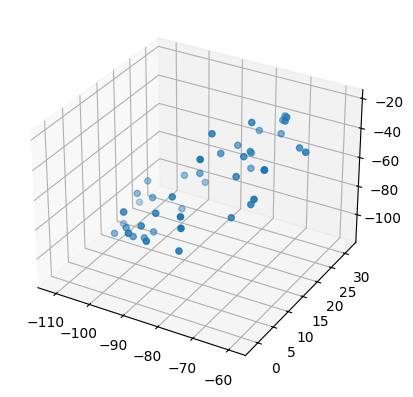

In [37]:
# show pointcloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(POINTS[:, 0], POINTS[:, 1], POINTS[:, 2])
plt.show()


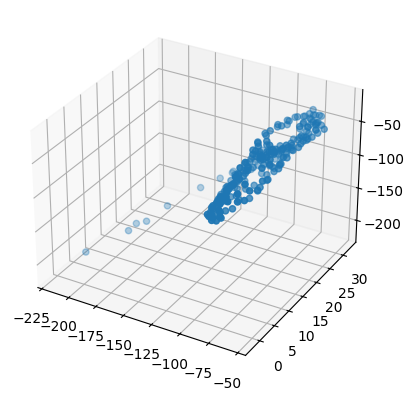

In [38]:
# show pointcloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointcloud[10:-10, 0], pointcloud[10:-10, 1], pointcloud[10:-10, 2])
plt.show()
